<a href="https://colab.research.google.com/github/barauna-lo/Code_Library/blob/main/FRB_Ploting_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --user cfod

In [ ]:
!pip install flask-ngrok

In [ ]:
pip install -U gitsome

In [ ]:
!pip install -U ipython

In [13]:
!gdown "https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/files/vault/AstroDataCitationDOI/CISTI.CANFAR/21.0007/data/waterfalls/data/FRB20180725A_waterfall.h5"

Downloading...
From: https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/files/vault/AstroDataCitationDOI/CISTI.CANFAR/21.0007/data/waterfalls/data/FRB20180725A_waterfall.h5
To: /content/FRB20180725A_waterfall.h5
100% 35.5M/35.5M [00:20<00:00, 1.74MB/s]


In [68]:
import h5py
filename = 'FRB20180725A_waterfall.h5'

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data = list(f[a_group_key])

Keys: <KeysViewHDF5 ['frb']>


In [69]:
file_name = "FRB20180725A_waterfall.h5"
data = h5py.File(file_name, "r")

In [71]:
import numpy as np
data = data["frb"]
eventname = data.attrs["tns_name"].decode()
wfall = data["wfall"][:]
model_wfall = data["model_wfall"][:]
plot_time = data["plot_time"][:]
plot_freq = data["plot_freq"][:]
ts = data["ts"][:]
model_ts = data["model_ts"][:]
spec = data["spec"][:]
model_spec = data["model_spec"][:]
extent = data["extent"][:]
dm = data.attrs["dm"][()]
scatterfit = data.attrs["scatterfit"][()]
cal_obs_date = data.attrs["calibration_observation_date"].decode()
cal_source_name = data.attrs["calibration_source_name"].decode()
cal_wfall =  data["calibrated_wfall"][:]

dt = np.median(np.diff(plot_time)) # the delta (time) between time bins 
# this value is the same for both caliberated and uncalibrated data


In [72]:
q1 = np.nanquantile(spec, 0.25)
q3 = np.nanquantile(spec, 0.75)
iqr = q3 - q1

# additional masking of channels with RFI
rfi_masking_var_factor = 3

channel_variance = np.nanvar(wfall, axis=1)
mean_channel_variance = np.nanmean(channel_variance)

with np.errstate(invalid="ignore"):
    rfi_mask = (channel_variance > \
                rfi_masking_var_factor * mean_channel_variance) \
                | (spec[::-1] < q1 - 1.5 * iqr) | (spec[::-1] > q3 + 1.5 * iqr)
wfall[rfi_mask,...] = np.nan
model_wfall[rfi_mask,...] = np.nan
spec[rfi_mask[::-1]] = np.nan

# remake time-series after RFI masking
ts = np.nansum(wfall, axis=0)
model_ts = np.nansum(model_wfall, axis=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: Degrees of freedom <= 0 for slice.
  


In [73]:
def boxcar_kernel(width):
    width = int(round(width, 0))
    return np.ones(width, dtype="float32") / np.sqrt(width)


def find_burst(ts, min_width=1, max_width=128):
    min_width = int(min_width)
    max_width = int(max_width)
    # do not search widths bigger than timeseries
    widths = list(range(min_width, min(max_width + 1, len(ts)-2)))
    # envelope finding
    snrs = np.empty_like(widths, dtype=float)
    peaks = np.empty_like(widths, dtype=int)
    for i in range(len(widths)):
        convolved = scipy.signal.convolve(ts, boxcar_kernel(widths[i]), mode="same")
        peaks[i] = np.nanargmax(convolved)
        snrs[i] = convolved[peaks[i]]
    best_idx = np.nanargmax(snrs)
    return peaks[best_idx], widths[best_idx], snrs[best_idx]

In [74]:
def bin_freq_channels(data, fbin_factor=4):
    num_chan = data.shape[0]
    if num_chan % fbin_factor != 0:
        raise ValueError("frequency binning factor `fbin_factor` should be even")
    data = np.nanmean(data.reshape((num_chan // fbin_factor, fbin_factor) + data.shape[1:]), axis=1)
    return data


ValueError: ignored

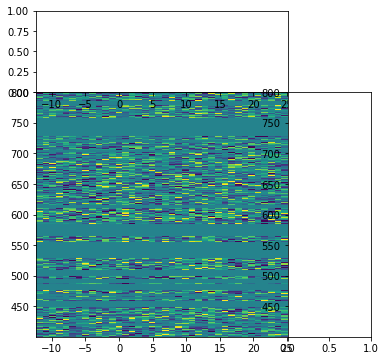

In [77]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(6,6))
## Set up the image grid
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, width_ratios=[3, 1],height_ratios=[1, 3], hspace=0.0, wspace=0.0)
data_im = plt.subplot(gs[2])
data_ts = plt.subplot(gs[0], sharex=data_im)
data_spec = plt.subplot(gs[3], sharey=data_im)


### time stamps relative to the peak
peak_idx = np.argmax(ts)
extent[0] = extent[0] - plot_time[peak_idx]
extent[1] = extent[1] - plot_time[peak_idx]
plot_time -= plot_time[peak_idx]

# prepare time-series for histogramming
plot_time -= dt / 2.
plot_time = np.append(plot_time, plot_time[-1] + dt)

cmap = plt.cm.viridis

### plot dynamic spectrum
wfall[np.isnan(wfall)] = np.nanmedian(wfall)   # replace nans in the data with the data median
# use standard deviation of residuals to set color scale
vmin = np.nanpercentile(wfall, 1)
vmax = np.nanpercentile(wfall, 99)

data_im.imshow(wfall, aspect="auto", interpolation="none",
                extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)

### plot time-series
data_ts.plot(plot_time, np.append(ts, ts[-1]), color="tab:gray",
                drawstyle="steps-post")

### plot spectrum
data_spec.plot(spec, plot_freq, color="tab:gray")

### plot model time-series and spectrum
if scatterfit:
    data_spec.plot(model_spec, plot_freq, color=cmap(0.25))
    data_ts.plot(plot_time, np.append(model_ts, model_ts[-1]),
                    color=cmap(0.25), drawstyle="steps-post", lw=2)
else:
    data_spec.plot(model_spec, plot_freq, color=cmap(0.5))
    data_ts.plot(plot_time, np.append(model_ts, model_ts[-1]),
                    color=cmap(0.5), drawstyle="steps-post", lw=1)


## BEautify plot
# remove some labels and ticks for neatness
plt.setp(data_ts.get_xticklabels(), visible=False)
data_ts.set_yticklabels([], visible=True)
data_ts.set_yticks([])
data_ts.set_xlim(extent[0], extent[1])
plt.setp(data_spec.get_yticklabels(), visible=False)
data_spec.set_xticklabels([], visible=True)
data_spec.set_xticks([])
data_spec.set_ylim(extent[2], extent[3])
plt.setp(data_im.get_xticklabels(), fontsize=9)
plt.setp(data_im.get_yticklabels(), fontsize=9)


#### highlighting the width of the pulse
data_ts.axvspan(max(plot_time.min(),
                        plot_time[peak] + 0.5 * dt \
                        - (0.5 * width) * dt),
                    min(plot_time.max(),
                        plot_time[peak] + 0.5 * dt \
                        + (0.5 * width) * dt),
                    facecolor="tab:blue", edgecolor=None, alpha=0.1)


##### add event ID and DM labels
xlim = data_ts.get_xlim()
ylim = data_ts.get_ylim()

# add 20% extra white space at the top
span = np.abs(ylim[1]) + np.abs(ylim[0])
data_ts.set_ylim(ylim[0], ylim[1] + 0.2 * span)
ylim = data_ts.get_ylim()

ypos = (ylim[1] - ylim[0]) * 0.9 + ylim[0]
xpos = (xlim[1] - xlim[0]) * 0.98 + extent[0]
data_ts.text(xpos, ypos, "{}\nDM: {:.1f} pc/cc\nSNR: {:.2f}".format(eventname, dm,snr), ha="right",
                va="top", fontsize=9)

data_im.locator_params(axis="x", min_n_ticks=3)
data_im.set_yticks([400, 500, 600, 700, 800])
data_im.set_ylabel("Frequency [MHz]", fontsize=9)
data_im.set_xlabel("Time [ms]", fontsize=9)


In [46]:
cal_ts = np.nanmean(cal_wfall, axis = 0)

In [61]:
eventname

'FRB20180725A'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


AttributeError: ignored

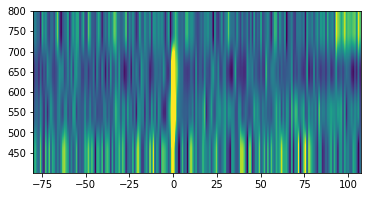

In [49]:
cal_wfall[np.isnan(cal_wfall)] = np.nanmedian(cal_wfall)   # replace nans in the data with the data median
#bin frequency channels such that we have 16,384/16 = 1024 frequency channels 
cal_wfall = bin_freq_channels(cal_wfall,16) 
vmin = np.nanpercentile(cal_wfall, 1)
vmax = np.nanpercentile(cal_wfall, 99)

times = np.arange(len(cal_ts))*dt
peak_idx = np.argmax(cal_ts)
times -= times[peak_idx]
times -= dt / 2.

extent[0] = times[0]
extent[1] = times[-1]

fig = plt.figure(figsize=(5,5), constrained_layout=True)
#layout = """
# A
# C
# """
#ax_dict = fig.subplot_mosaic(layout)
plt.subplot(2,1,1)
plt.imshow(cal_wfall, aspect="auto", vmin=vmin,vmax=vmax, extent = extent )
plt.subplot(2,1,1)
plt.set_title(f"Waterfall of {eventname} \n Calibrated to {cal_source_name} on {cal_obs_date}")
plt.subplot(2,1,1)
plt.set_yticks([400, 500, 600, 700, 800])
ax_dict["C"].plot(times,cal_ts, drawstyle="steps-post")
ax_dict["C"].set_xlabel("Time [ms]")
ax_dict["C"].set_title(f"Time Series of {eventname} \nCalibrated to {cal_source_name} on {cal_obs_date} \
        \n Peak flux = {cal_ts[peak_idx]:.3f} Jy")
plt.subplot(2,1,1)
plt.set_ylabel("Frequency [MHz]")
plt.subplot(2,1,1)
plt.set_ylabel("Flux [Jy]")


In [55]:
import pandas as pd

In [57]:
df = pd.DataFrame()

df.insert(0,'times',times)#,random_state=8666)) #insert new collums
df.insert(1,'cal_ts',cal_ts)

In [60]:
df.to_csv('frb.csv')

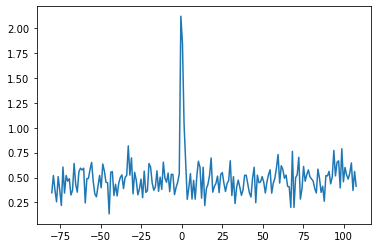

In [59]:
plt.plot(df['times'],df['cal_ts'])

Text(0.5, 1.0, 'Time Series of FRB20180725A \nCalibrated to SNR_G130.7+03.1 on 2018-09-29         \n Peak flux = 2.118 Jy')

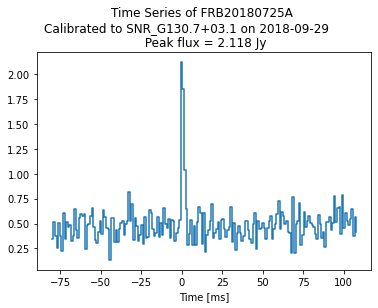

In [64]:
plt.plot(times,cal_ts, drawstyle="steps-post")
plt.xlabel("Time [ms]")
plt.title(f"Time Series of {eventname} \nCalibrated to {cal_source_name} on {cal_obs_date} \
        \n Peak flux = {cal_ts[peak_idx]:.3f} Jy")


In [ ]:
#Alternativa 
# GERANDO SÉRIES TEMPORAIS DE RUÍDOS COLORIDOS
colorData = pd.DataFrame()
#SetUp a noise class
beta,dataSize = [0.2,1,2],len_size 
#beta,dataSize = [0,1,2],2**10
#Creat dataSize
for i in range(len(beta)): colorData.insert(i,'beta'+str(i),cn.powerlaw_psd_gaussian(beta[i],dataSize))#,random_state=8666)) #insert new collums